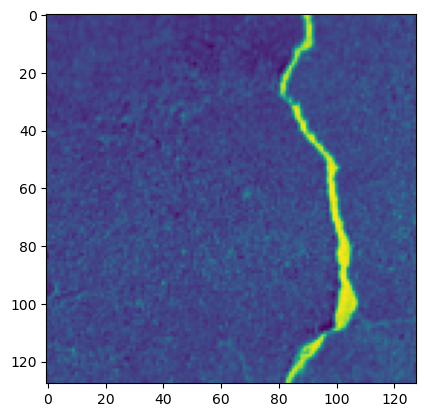

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

filenames = glob('crack_segmentation_dataset/images/DeepCrack*.jpg')
X = np.random.choice(filenames)
img = cv2.imread(X, -1)
img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
img = 255-cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(img)
plt.show()

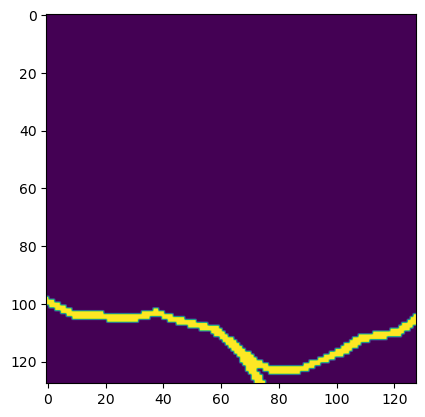

In [2]:
import importlib
import cyclegan
cyclegan = importlib.reload(cyclegan)

crack = cyclegan.DataGenerator([], 128, 128).generate_crack()

plt.figure()
plt.imshow(crack)
plt.show()

In [3]:
cyclegan_model = cyclegan.CycleGAN(128, 128)

TypeError: __init__() got multiple values for argument 'size'

In [ ]:
from tensorflow.keras.models import load_model

cyclegan_model.g_model_AB = load_model('initial_models/g_model_AB.h5')
cyclegan_model.g_model_BA = load_model('initial_models/g_model_BA.h5')

In [ ]:
def normalise_image(img):

    return ((img - np.amin(img)) / (np.amax(img) - np.amin(img)))*2-1

# A 2 B

In [ ]:
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.show()

pred = cyclegan_model.g_model_AB.predict(np.expand_dims(normalise_image(img), axis=[0, -1]))

plt.figure()
plt.imshow(np.squeeze(pred))
plt.show()

# B 2 A

In [ ]:
plt.figure()
plt.imshow(crack)
plt.colorbar()
plt.show()

pred_BA = cyclegan_model.g_model_BA.predict(np.expand_dims(normalise_image(crack), axis=[0, -1]))

plt.figure()
plt.imshow(np.squeeze(pred_BA))
plt.show()

In [ ]:
type(pred_BA)

# Gradio Experiment

In [ ]:
import gradio as gr

def function(img):
    print('image received')
    print(type(img))
    print(np.shape(img))
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img = ((img - np.amin(img)) / (np.amax(img) - np.amin(img)))*2-1
    img = np.expand_dims(img, axis=[0, -1])
    pred_BA = cyclegan_model.g_model_BA.predict(img)
    pred_BA = np.squeeze(pred_BA)

    pred_BA = (pred_BA - np.amin(pred_BA)) / (np.amax(pred_BA) - np.amin(pred_BA))

    return pred_BA

gr.Interface(fn=function, 
             inputs=cp,
             outputs=gr.outputs.Image(type="numpy", label="Output"),
             live=True).launch()


In [ ]:
gr.Sketchpad(kwargs={'shape':(128, 128)})

In [ ]:
sp = gr.Sketchpad()
sp.shape = (1024, 1024)

In [ ]:
cp = gr.Image(tool='color-sketch', source='canvas', image_mode='L')
cp.shape = (128, 128)

In [ ]:
output_image = gr.Image(image_mode='L', shape=(128, 128))